In [21]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay,confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from model_module import model_preparation, best_model, model_preparation_multi_class
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [ ]:
df = pd.read_csv("./hindalco_eq_1h_2018_2025.csv ").set_index("datetime").drop(columns=["timestamp"])

In [23]:
df

,open,high,low,close,volume
datetime,,,,,
2018-01-01 10:15:00+05:30,273.00,274.45,271.50,271.55,305535
2018-01-01 10:30:00+05:30,271.55,271.55,270.60,271.40,133992
2018-01-01 10:45:00+05:30,271.40,271.70,270.85,271.25,65111
2018-01-01 11:00:00+05:30,271.10,272.00,270.80,271.30,100891
2018-01-01 11:15:00+05:30,271.30,272.00,271.15,272.00,59146
...,...,...,...,...,...
2025-12-12 15:15:00+05:30,853.50,854.80,853.15,854.00,129226
2025-12-12 15:30:00+05:30,854.00,854.00,850.55,851.75,209829
2025-12-12 15:45:00+05:30,851.70,854.00,851.40,851.95,156092


#### Creating Technical Analysis features

    Calculate relative volume ratio

In [24]:
df = df.copy()
lookback = 20  # 20 bars = 5 hours of 15min data

df["volume_ma"] = df["volume"].rolling(window=lookback).mean()
df["volume_ratio"] = df["volume"] / df["volume_ma"]

# Clean up
df = df.dropna(how="any")

    Calculate RSI

In [25]:
# RSI calculation
def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Add RSI with standard 14-period
df["rsi_14"] = calculate_rsi(df["close"], period=14)

# Clean up
df = df.dropna(how="any")

# Check the feature
print("RSI Statistics:")
print(df["rsi_14"].describe())
print(f"\nOverbought (>70): {(df['rsi_14'] > 70).sum()} bars")
print(f"Oversold (<30): {(df['rsi_14'] < 30).sum()} bars")


RSI Statistics:
count    49027.000000
mean        50.338072
std         18.206251
min          0.000000
25%         36.904762
50%         50.595238
75%         63.942308
max        100.000000
Name: rsi_14, dtype: float64

Overbought (>70): 7598 bars
Oversold (<30): 7218 bars


In [26]:
df.head()

,open,high,low,close,volume,volume_ma,volume_ratio,rsi_14
datetime,,,,,,,,
2018-01-02 12:00:00+05:30,271.40,271.65,270.90,271.45,86231,244311.30,0.352955,45.238095
2018-01-02 12:15:00+05:30,271.45,271.55,270.80,271.25,65239,245760.60,0.265458,44.764398
2018-01-02 12:30:00+05:30,271.25,271.40,270.80,270.80,107367,247126.65,0.434461,43.444730
2018-01-02 12:45:00+05:30,270.80,271.00,269.65,270.20,153394,253280.70,0.605628,28.615385
2018-01-02 13:00:00+05:30,270.20,271.15,270.00,270.60,98514,255360.25,0.385784,46.543779


    MACD

In [27]:
# MACD calculation
def calculate_macd(data, fast=12, slow=26, signal=9):
    ema_fast = data.ewm(span=fast, adjust=False).mean()
    ema_slow = data.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    return macd_line, signal_line, macd_histogram

df["macd"], df["macd_signal"], df["macd_hist"] = calculate_macd(df["close"])

# Normalize MACD features by price (make them relative)
df["macd_norm"] = df["macd"] / df["close"]
df["macd_hist_norm"] = df["macd_hist"] / df["close"]

# Clean up
df = df.dropna(how="any")

print("MACD Statistics:")
print(df[["macd_norm", "macd_hist_norm"]].describe())

MACD Statistics:
          macd_norm  macd_hist_norm
count  49027.000000    4.902700e+04
mean       0.000086    7.517415e-07
std        0.005306    1.561859e-03
min       -0.050001   -1.909532e-02
25%       -0.002520   -8.011399e-04
50%        0.000227   -2.350711e-05
75%        0.003017    7.982494e-04
max        0.034619    1.298030e-02


    Volatility

    Moving averages

In [28]:
# Moving averages (just for calculation, not direct features)
df["5ma"] = df["close"].rolling(5).mean()
df["10ma"] = df["close"].rolling(10).mean()
df["50ma"] = df["close"].rolling(50).mean()
df["200ma"] = df["close"].rolling(200).mean()  # Fixed: was 100

# RELATIVE features (normalized by price)
df["5_10_ma_diff_pct"] = (df["5ma"] - df["10ma"]) / df["close"]
df["close_5ma_diff_pct"] = (df["close"] - df["5ma"]) / df["close"]
df["close_10ma_diff_pct"] = (df["close"] - df["10ma"]) / df["close"]
df["golden_cross_pct"] = (df["50ma"] - df["200ma"]) / df["close"]

# Additional useful MA features
df["close_50ma_diff_pct"] = (df["close"] - df["50ma"]) / df["close"]
df["close_200ma_diff_pct"] = (df["close"] - df["200ma"]) / df["close"]

# Slope/momentum of MAs (rate of change)
df["5ma_roc"] = df["5ma"].pct_change(periods=5)
df["50ma_roc"] = df["50ma"].pct_change(periods=10)


In [29]:
# High-Low range features
df["hl_range"] = (df["high"] - df["low"]) / df["close"]  # Normalized
df["hl_range_ma"] = df["hl_range"].rolling(20).mean()
df["hl_range_ratio"] = df["hl_range"] / df["hl_range_ma"]  # Current vs average

# Close position within bar
df["close_position"] = (df["close"] - df["low"]) / (df["high"] - df["low"])  # 0 to 1

df = df.dropna()

#### Candlestick/Microsturcture Features

In [30]:
# === CANDLESTICK BODY & WICKS ===
df["body_size"] = abs(df["close"] - df["open"]) / df["close"]
df["upper_wick"] = (df["high"] - df[["open", "close"]].max(axis=1)) / df["close"]
df["lower_wick"] = (df[["open", "close"]].min(axis=1) - df["low"]) / df["close"]

# Body direction
df["body_direction"] = np.sign(df["close"] - df["open"])

# === OPEN-CLOSE RELATIONSHIPS ===
df["open_close_diff"] = (df["close"] - df["open"]) / df["close"]
df["high_close_diff"] = (df["high"] - df["close"]) / df["close"]
df["low_close_diff"] = (df["close"] - df["low"]) / df["close"]

# === VOLUME-WEIGHTED PRICE (VWAP) ===
df["vwap_5"] = (df["close"] * df["volume"]).rolling(5).sum() / df["volume"].rolling(5).sum()
df["vwap_10"] = (df["close"] * df["volume"]).rolling(10).sum() / df["volume"].rolling(10).sum()
df["vwap_5_diff"] = (df["close"] - df["vwap_5"]) / df["close"]
df["vwap_10_diff"] = (df["close"] - df["vwap_10"]) / df["close"]

# === MOMENTUM OF MICROSTRUCTURE ===
df["close_position_change"] = df["close_position"].diff()
df["body_size_ratio"] = df["body_size"] / df["body_size"].rolling(10).mean()

# === BUYING/SELLING PRESSURE PROXIES ===
# Approximation: If close near high = buying pressure
df["buying_pressure"] = (df["close"] - df["low"]) / (df["high"] - df["low"] + 1e-10)
df["selling_pressure"] = (df["high"] - df["close"]) / (df["high"] - df["low"] + 1e-10)

# Clean up
df = df.dropna()

print(f"Added microstructure features. New shape: {df.shape}")

Added microstructure features. New shape: (48811, 44)


#### Create log returns target

In [31]:
df["close_log_return"] = np.log(df["close"] / df["close"].shift(1))
df = df.dropna(how="any")

In [32]:
df = df.copy()
df["shifted_log_return"] = df["close_log_return"].shift(-1)

#### Creating lagged features

In [33]:
df["close_log_return_lag1"] = df["shifted_log_return"].shift(1)
df["close_log_return_lag2"] = df["shifted_log_return"].shift(2)
df["close_log_return_lag3"] = df["shifted_log_return"].shift(3)
df = df.dropna(how="any")

In [34]:
df

,open,high,low,close,volume,volume_ma,volume_ratio,rsi_14,macd,macd_signal,...,vwap_10_diff,close_position_change,body_size_ratio,buying_pressure,selling_pressure,close_log_return,shifted_log_return,close_log_return_lag1,close_log_return_lag2,close_log_return_lag3
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-12 15:00:00+05:30,268.05,268.20,267.50,268.20,74860,158801.65,0.471406,42.857143,-0.236459,-0.114623,...,0.000470,0.733333,0.218818,1.000000,0.000000,0.000559,0.001304,0.000559,-0.001864,0.002983
2018-01-12 15:15:00+05:30,268.20,268.60,267.95,268.55,106763,140953.55,0.757434,41.401274,-0.208583,-0.133415,...,0.002043,-0.076923,0.488540,0.923077,0.076923,0.001304,0.000372,0.001304,0.000559,-0.001864
2018-01-12 15:30:00+05:30,268.55,269.15,267.90,268.65,153400,137272.80,1.117483,42.948718,-0.176389,-0.142010,...,0.002608,-0.323077,0.151093,0.600000,0.400000,0.000372,0.000186,0.000372,0.001304,0.000559
2018-01-12 15:45:00+05:30,268.65,269.15,268.15,268.70,209329,141648.50,1.477806,44.155844,-0.145167,-0.142641,...,0.002780,-0.050000,0.080387,0.550000,0.450000,0.000186,-0.000186,0.000186,0.000372,0.001304
2018-01-12 16:00:00+05:30,268.70,269.50,268.20,268.65,402625,156638.85,2.570403,42.384106,-0.123039,-0.138721,...,0.000844,-0.203846,0.112167,0.346154,0.653846,-0.000186,-0.000745,-0.000186,0.000186,0.000372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-12 15:00:00+05:30,850.70,855.00,850.45,853.20,191296,323596.50,0.591156,90.332326,5.701434,5.289169,...,0.005470,0.271062,2.292777,0.604396,0.395604,0.002934,0.000937,0.002934,0.000823,0.000000
2025-12-12 15:15:00+05:30,853.50,854.80,853.15,854.00,129226,290837.65,0.444323,90.153846,5.809065,5.393149,...,0.005360,-0.089244,0.490122,0.515152,0.484848,0.000937,-0.002638,0.000937,0.002934,0.000823
2025-12-12 15:30:00+05:30,854.00,854.00,850.55,851.75,209829,281480.40,0.745448,82.072829,5.647704,5.444060,...,0.001951,-0.167325,1.887403,0.347826,0.652174,-0.002638,0.000235,-0.002638,0.000937,0.002934


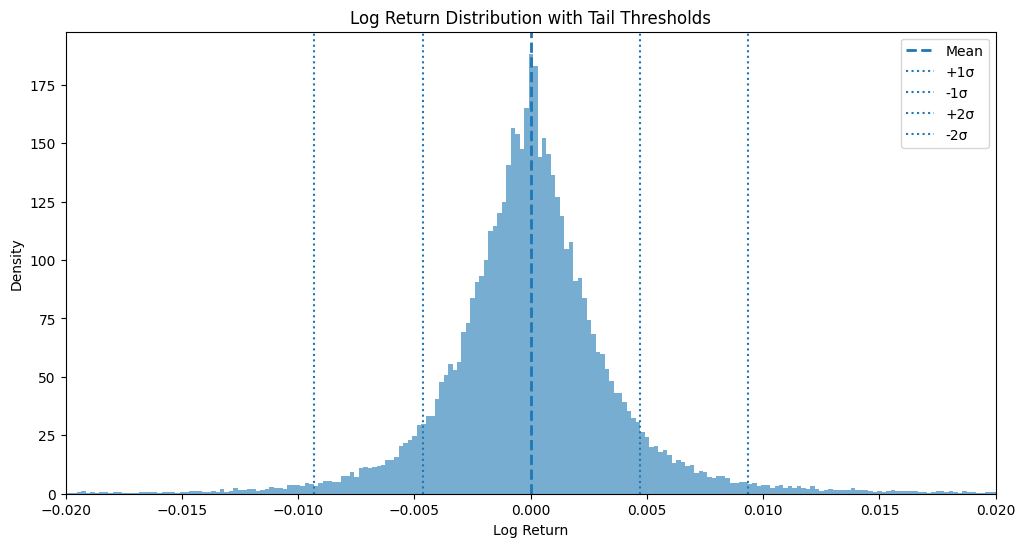

In [35]:
y_clean = df["close_log_return"].dropna()

mu = y_clean.mean()
sigma = y_clean.std()

fig, ax = plt.subplots(figsize=(12, 6))

# Histogram
ax.hist(
    y_clean,
    bins=1000,
    density=True,
    alpha=0.6
)
ax.set_xlim(-0.02, 0.02)
# Mean & std lines
ax.axvline(mu, linestyle="--", linewidth=2, label="Mean")
ax.axvline(mu + sigma, linestyle=":", linewidth=1.5, label="+1σ")
ax.axvline(mu - sigma, linestyle=":", linewidth=1.5, label="-1σ")
ax.axvline(mu + 2*sigma, linestyle=":", linewidth=1.5, label="+2σ")
ax.axvline(mu - 2*sigma, linestyle=":", linewidth=1.5, label="-2σ")


ax.set_title("Log Return Distribution with Tail Thresholds")
ax.set_xlabel("Log Return")
ax.set_ylabel("Density")

ax.legend(loc="upper right")
plt.show()


In [36]:
X = df[[
    "buying_pressure",
    "selling_pressure",
    "close_position",
    "close_5ma_diff_pct",
    "high_close_diff",
    "vwap_5_diff",
    "body_size",
    "body_size_ratio",
    "volume_ratio",
    "low_close_diff"
]]


y = (df["shifted_log_return"] > 0).astype(int)


#### Creating the model

    Baseline

In [37]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Simple 60/20/20 split
train_size = int(0.6 * len(df))
val_size = int(0.2 * len(df))

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_val = X.iloc[train_size:train_size + val_size]
y_val = y.iloc[train_size:train_size + val_size]

X_test = X.iloc[train_size + val_size:]
y_test = y.iloc[train_size + val_size:]

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# Step 2: Train baseline XGBoost
baseline_model = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.05,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

baseline_model.fit(X_train, y_train)

# Step 3: Evaluate on all sets
train_acc = baseline_model.score(X_train, y_train)
val_acc = baseline_model.score(X_val, y_val)
test_acc = baseline_model.score(X_test, y_test)

print(f"\nBaseline Model:")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Step 4: Validation set classification report
y_val_pred = baseline_model.predict(X_val)
print("\nValidation Set Report:")
print(classification_report(y_val, y_val_pred))

Train: 29283, Val: 9761, Test: 9762

Baseline Model:
Train Accuracy: 0.5644
Val Accuracy: 0.5199
Test Accuracy: 0.5170

Validation Set Report:
              precision    recall  f1-score   support

           0       0.52      0.82      0.64      5019
           1       0.51      0.21      0.29      4742

    accuracy                           0.52      9761
   macro avg       0.52      0.51      0.47      9761
weighted avg       0.52      0.52      0.47      9761

